# LogRatioEstimator_Ndim

First we need some imports.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy import stats
import pylab as plt
import torch
import swyft
import dynesty

In [49]:
N = 10000  # Number of samples
D = 2
z = np.random.rand(N, D)*2 - 1

In [50]:
#z = prop

In [51]:
x = z + np.random.randn(N, D)*0.1

In [52]:
samples = swyft.Samples(x = x.astype(np.float32), z = z.astype(np.float32))

In [53]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.logratios1 = swyft.LogRatioEstimator_1dim(num_features = D*2, num_params = D, varnames = 'z')
        self.optimizer_init = swyft.OptimizerInit(torch.optim.Adam, dict(lr = 1e-3))

    def forward(self, A, B):
        z = B['z']
        x = A['x']
        zA = A['z']
        x, z = swyft.equalize_tensors(x, z)
        x, zA = swyft.equalize_tensors(x, zA)
        f = torch.cat([x, zA], dim=-1)
        f = f.unsqueeze(1)
        f = f.repeat((1, D, 1))
        mask = torch.ones(D, D*2)
        for i in range(D):
            mask[i, -D+i:] = 0
        f = f*mask
        logratios1 = self.logratios1(f, z)
        return logratios1

In [54]:
trainer = swyft.SwyftTrainer(accelerator = 'cpu', devices=1, max_epochs = 10, precision = 32)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:200: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


In [55]:
dm = swyft.SwyftDataModule(samples, fractions = [0.8, 0.1, 0.1], num_workers = 0, batch_size = 32)

In [56]:
network = Network()

In [57]:
trainer.fit(network, dm)


  | Name       | Type                   | Params
------------------------------------------------------
0 | logratios1 | LogRatioEstimator_1dim | 35.2 K
------------------------------------------------------
35.2 K    Trainable params
0         Non-trainable params
35.2 K    Total params
0.141     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [58]:
network.train(False);

In [59]:
#A = swyft.Sample(x = torch.tensor(np.array([[x0]]).astype(np.float32)))
def loglike(u):
    B = swyft.Samples(z = torch.tensor(np.array([u]).astype(np.float32)))
    A = swyft.Sample(x = torch.zeros((1,D)), z=B['z'])
    pred = network(A, B)
    lnL = pred.logratios.sum().item()
    return lnL

In [60]:
def prior_transform(u):
    return u*2-1

In [61]:
sampler = dynesty.NestedSampler(loglike, prior_transform, D,
                                       bound='multi', sample='rwalk', nlive = 1000, )#, live_points = [u, v, logl])

In [62]:
sampler.run_nested(maxcall=10000000, logl_max = 10, print_progress=True)


0it [00:00, ?it/s]
168it [00:00, 1675.31it/s, bound: 0 | nc: 1 | ncall: 1179 | eff(%): 14.249 | loglstar:   -inf < -15.973 < 10.000 | logz: -19.220 +/-  0.048 | dlogz: 23.070 >  1.009]
336it [00:00, 1582.99it/s, bound: 0 | nc: 1 | ncall: 1382 | eff(%): 24.313 | loglstar:   -inf < -13.402 < 10.000 | logz: -16.378 +/-  0.046 | dlogz: 20.052 >  1.009]
495it [00:00, 1431.18it/s, bound: 0 | nc: 1 | ncall: 1612 | eff(%): 30.707 | loglstar:   -inf < -11.528 < 10.000 | logz: -14.399 +/-  0.044 | dlogz: 17.911 >  1.009]
640it [00:00, 1301.95it/s, bound: 0 | nc: 3 | ncall: 1863 | eff(%): 34.353 | loglstar:   -inf < -9.927 < 10.000 | logz: -12.883 +/-  0.044 | dlogz: 16.249 >  1.009] 
772it [00:00, 1154.82it/s, bound: 0 | nc: 1 | ncall: 2142 | eff(%): 36.041 | loglstar:   -inf < -8.933 < 10.000 | logz: -11.735 +/-  0.043 | dlogz: 15.011 >  1.009]
890it [00:00, 1009.73it/s, bound: 0 | nc: 2 | ncall: 2443 | eff(%): 36.431 | loglstar:   -inf < -8.130 < 10.000 | logz: -10.905 +/-  0.043 | dlogz: 14.

3.2864084243774414 4.0998125076293945


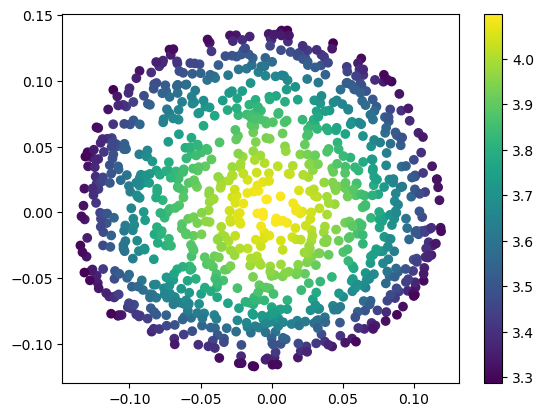

In [63]:
u = sampler.live_u
v = sampler.live_v
logl = sampler.live_logl
print(logl.min(), logl.max())
plt.scatter(v[:,0], v[:,1], c = logl)
plt.colorbar()

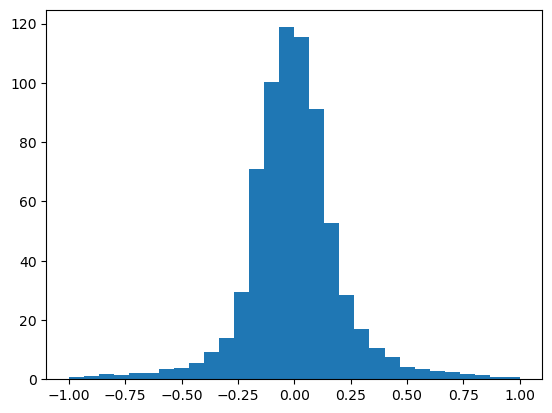

In [67]:
logl = sampler.results.logwt
u = sampler.results.samples_u*2-1
plt.hist(u[:,0], weights = np.exp(logl*0.2), bins = 30);

In [68]:
(sum(u[:,0]**2*np.exp(logl))/sum(np.exp(logl)))**0.5

0.10479976898346419

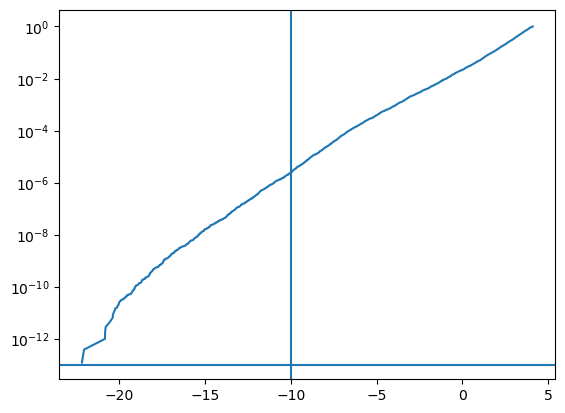

In [69]:
logl = sampler.results.logl
logwt = sampler.results.logwt
wt = np.exp(logwt-logwt.max())
wt = wt/wt.sum()
wtc = np.cumsum(wt)
plt.semilogy(logl, wtc)
plt.axhline(1e-13)
plt.axvline(-10)

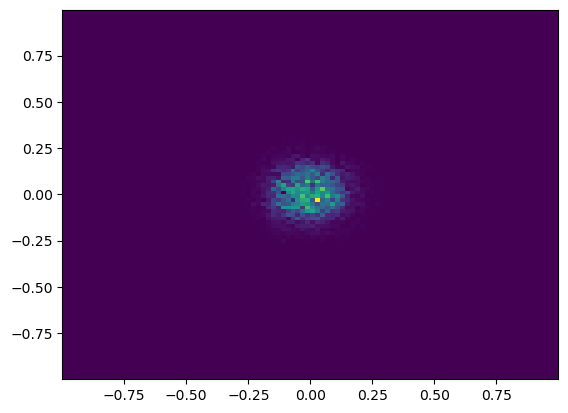

In [70]:
plt.hist2d(u[:,0], u[:,1], weights = np.exp(logl), bins = 100);

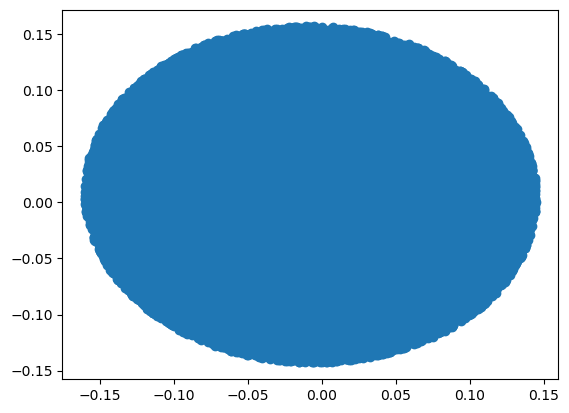

In [71]:
sampler.update()
prop = np.array([sampler.propose_unif()[0] for _ in range(30000)])*2-1
plt.scatter(prop[:,0], prop[:,1])